# Банки — Анализ оттока клиентов

## Цели и задачи

***Задача***

Проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.

- Провести исследовательский анализ данных,

- Выделить портреты клиентов, которые склонны уходить из банка,

- Сформулировать и проверить статистические гипотезы.

Гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.

Статистическую гипотезу относительно представленных данных

***Данные***

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- City — город,
- Gender — пол,
- Age — возраст,
- Objects — количество объектов в собственности,
- Balance — баланс на счёте,
- Products — количество продуктов, которыми пользуется клиент,
- CreditCard — есть ли кредитная карта,
- Loyalty — активный клиент,
- estimated_salary — заработная плата клиента,
- Churn — ушёл или нет.

## Загрузка и обзор данных

### Импорт библиотек и загрузка датасета

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import warnings
import scipy.stats as st
import math as mth
warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv('https://datasets/bank_dataset.csv')
except:
    df = pd.read_csv('/datasets/bank_dataset.csv')

### Обзор данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


В данных 10тыс строк и 12 столбцов, есть пропуски в столбце баланс. Типы данных в порядке, необходимо привести названия столбцов к единому регистру, оценить долю пропусков и проверить данные на наличие дубликатов. Зададим русские названия для удобного чтения графиков.

## Предобработка данных

### Замена названий

In [5]:
df.columns = [col.lower() for col in df.columns]
df = df.rename(columns = {'userid':'user_id','creditcard':'credit_card'})
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

### Оценим долю пропусков и кол-во дубликатов

In [6]:
print('Доля пропусков в %:', round(df['balance'].isna().sum()/len(df), 2) * 100)

Доля пропусков в %: 36.0


In [7]:
print('Явных дубликатов:', df.duplicated().sum(), 'Доля дубликатов:', df.duplicated().sum() / len(df))

Явных дубликатов: 0 Доля дубликатов: 0.0


Проверим неявные дубликаты:

In [8]:
display(df['city'].unique())
df['gender'].unique()

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

array(['Ж', 'М'], dtype=object)

### Создадим русские названия для удобства чтения графиков

In [9]:
rus_columns = ['id пользователя', 'кредитный скоринг', 'город', 'пол', 'возраст', 'объекты в собственности',
              'остаток на счете', 'используемые продукты', 'кредитная карта', 'лояльность', 'оценка зарплаты',
              'отток']
df_columns_dict = dict(zip(df.columns, rus_columns))
df_columns_dict

{'user_id': 'id пользователя',
 'score': 'кредитный скоринг',
 'city': 'город',
 'gender': 'пол',
 'age': 'возраст',
 'objects': 'объекты в собственности',
 'balance': 'остаток на счете',
 'products': 'используемые продукты',
 'credit_card': 'кредитная карта',
 'loyalty': 'лояльность',
 'estimated_salary': 'оценка зарплаты',
 'churn': 'отток'}

Мы привели названия колонок датасета к единому регистру, проверили на наличие пропусков и дубликатов. Доля пропусков в столбце Balance составляет 36% - это большое кол-во которое нельзя удалять, корректно заменить значения мы не сможем, значит придется продолжить исследование не изменяя данные. Дубликатов не обнаружено. Также мы создали словарь с русскими обозначениями для удобства чтения графиков.

Попробуем разобраться с чем связано большое количество пропусков в столбце balance

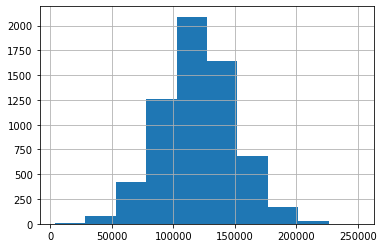

In [10]:
df['balance'].hist();

In [11]:
df['balance'].describe()

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64

Миниманльное значение 3768, нет данных которые находятся у нуля. Распределение нормальное, возможно пропуски это нулевой баланс на счету, в другом случае, вероятнее всего, у банка была бы информация об остаточном балансе клиентов. 

## Исследовательский анализ данных(EDA)

### Посмотрим на статистики

In [12]:
df_noid = df.drop('user_id', axis=1)

In [13]:
df_noid.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
score,10000.0,650.53,96.65,350.00,584.00,652.00,718.00,850.00
age,10000.0,38.92,10.49,18.00,32.00,37.00,44.00,92.00
objects,10000.0,5.01,2.89,0.00,3.00,5.00,7.00,10.00
balance,6383.0,119827.49,30095.06,3768.69,100181.98,119839.69,139512.29,250898.09
products,10000.0,1.53,0.58,1.00,1.00,1.00,2.00,4.00
credit_card,10000.0,0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,10000.0,0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,10000.0,100090.24,57510.49,11.58,51002.11,100193.92,149388.25,199992.48
churn,10000.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00


Средние и стандартные отклонения признаков

In [14]:
gender_dict = {'Ж':0,'М':1}
mean_std = df_noid.replace({'gender':gender_dict}).agg(['mean', 'std']).T.round(2)
mean_std

,mean,std
score,650.53,96.65
gender,0.55,0.50
age,38.92,10.49
objects,5.01,2.89
balance,119827.49,30095.06
products,1.53,0.58
credit_card,0.71,0.46
loyalty,0.52,0.50
estimated_salary,100090.24,57510.49
churn,0.20,0.40


Средний отток около 20%, далее разберем подробно количественные и категориальные признаки

### Распределения количественных признаков

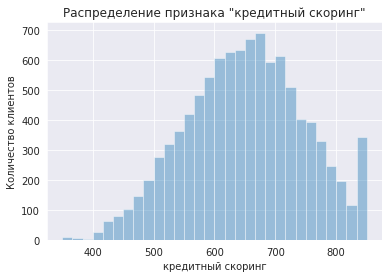

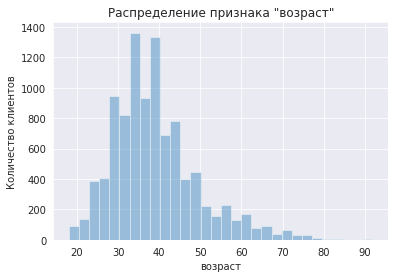

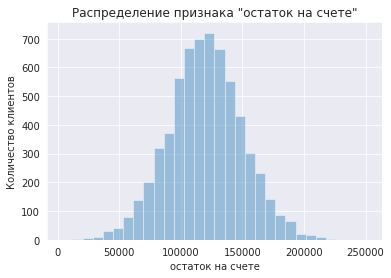

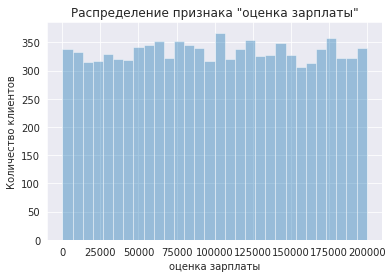

In [15]:
df_quantitative = df_noid[['score', 'age', 'balance', 'estimated_salary']]
with sns.axes_style('darkgrid'):
    for col in df_quantitative.columns:
        A = df[col]
        A_no_nan = A[~np.isnan(A)]
    
        sns.distplot(A_no_nan, kde=False, bins=30)
        plt.title(f'Распределение признака "{df_columns_dict[col]}"')
        plt.xlabel(df_columns_dict[col])
        plt.ylabel('Количество клиентов')
        plt.show()

За исключением кредитного скоринга, все распределения выглядят адекватно. В колонке кредитного скоринга видим выброс в районе максимального значения 850, возможно есть клиенты с большим кол-вом очков, но данные обрезаны и из за этого скачок кажется выбросом. Распределение зарплаты довольно схоже, вероятно группы клиентов в данных подбиралась по равнозначной зарплате. 

### Категориальные и дискретные признаки

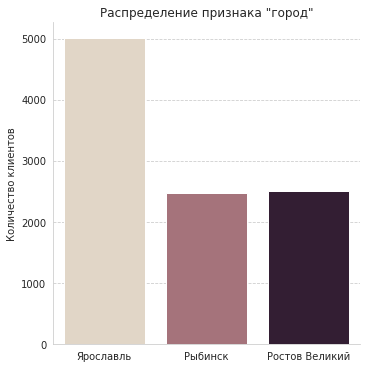

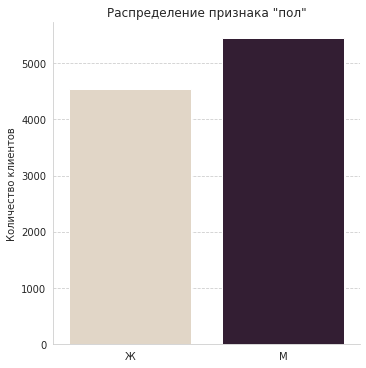

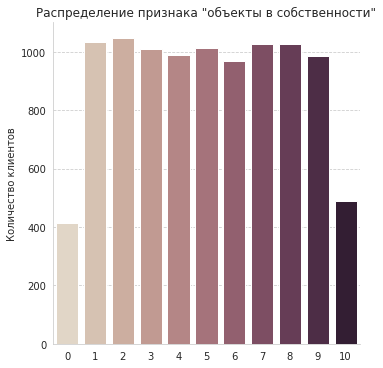

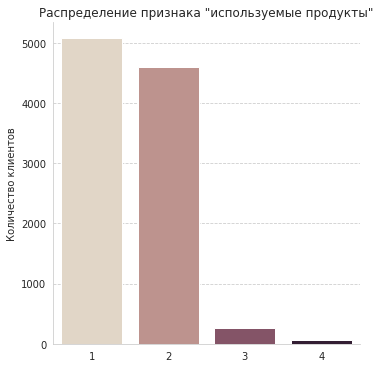

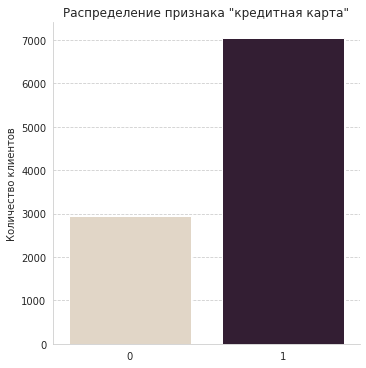

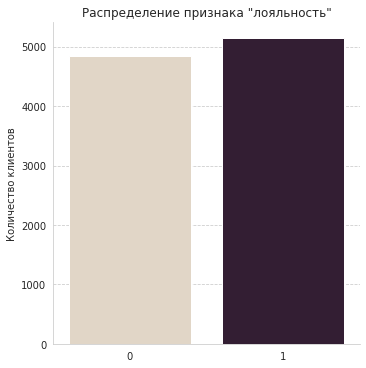

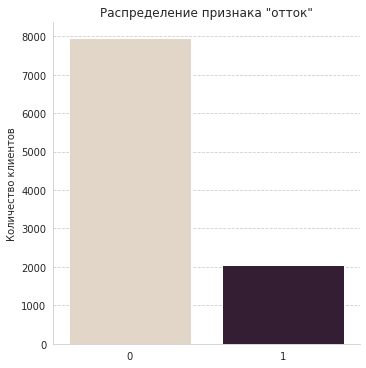

In [16]:
df_category = df_noid[['city', 'gender', 'objects', 'products', 'credit_card', 'loyalty', 'churn']]
with sns.axes_style('whitegrid'):
    for col in df_category.columns:
        sns.catplot(x=col, kind='count', palette="ch:.25", data=df)
        plt.title(f'Распределение признака "{df_columns_dict[col]}"')
        plt.xlabel('')
        plt.ylabel('Количество клиентов')
        plt.grid(True, axis='y', linestyle='--')
        plt.show()

Больше всего клиентов из Ярославля - около 5тыс, в Рыбинске и Ростове Великом кол-во клиентов примерно одинаковое - около 2.5тыс. Женщины составляют долю 45%, а 55% клиентов мужчины. Количество объектов в собственности выглядит схоже, как и распределение зарплаты, кроме хвостов в 0 и 10 объектов, возможно это связано с особенностью выборки.
Подавляющее больинство клиентов пользуются 1-2 продуктами банка. Около 70% клиентов пользуются кредитными картами. Процент лояльности(активности) выше 50%, показатели оттока около 20%.

### Изучим корреляции

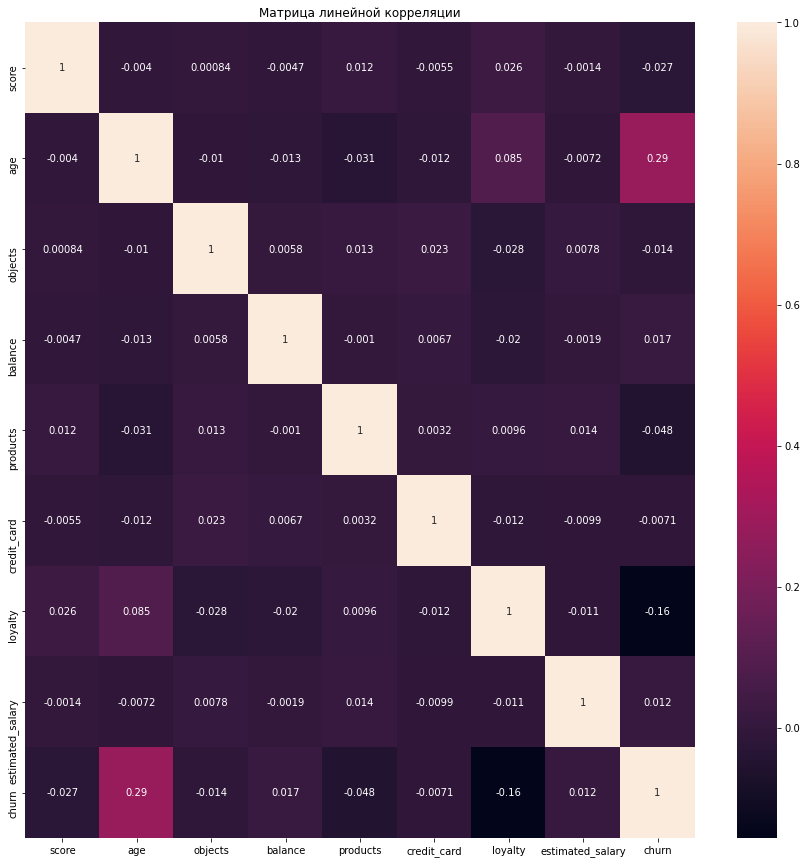

In [17]:
plt.figure(figsize = (15,15))
sns.heatmap(df_noid.corr(), annot=True)
plt.title('Матрица линейной корреляции')
plt.show()

На тепловой карте можно увидеть слабую корреляцию между параметрами, немного выделяются только соотношения оттока и возраста, оттока и лояльности(активности).

In [18]:
df_binar = pd.get_dummies(df_noid, columns=['city', 'gender'])
df_binar

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,619,42,2,NaN,1,1,1,101348.88,1,0,0,1,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
3,699,39,1,NaN,2,0,0,93826.63,0,0,0,1,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,NaN,2,1,0,96270.64,0,0,0,1,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1,0,1
9997,709,36,7,NaN,1,0,1,42085.58,1,0,0,1,1,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,0,0,1


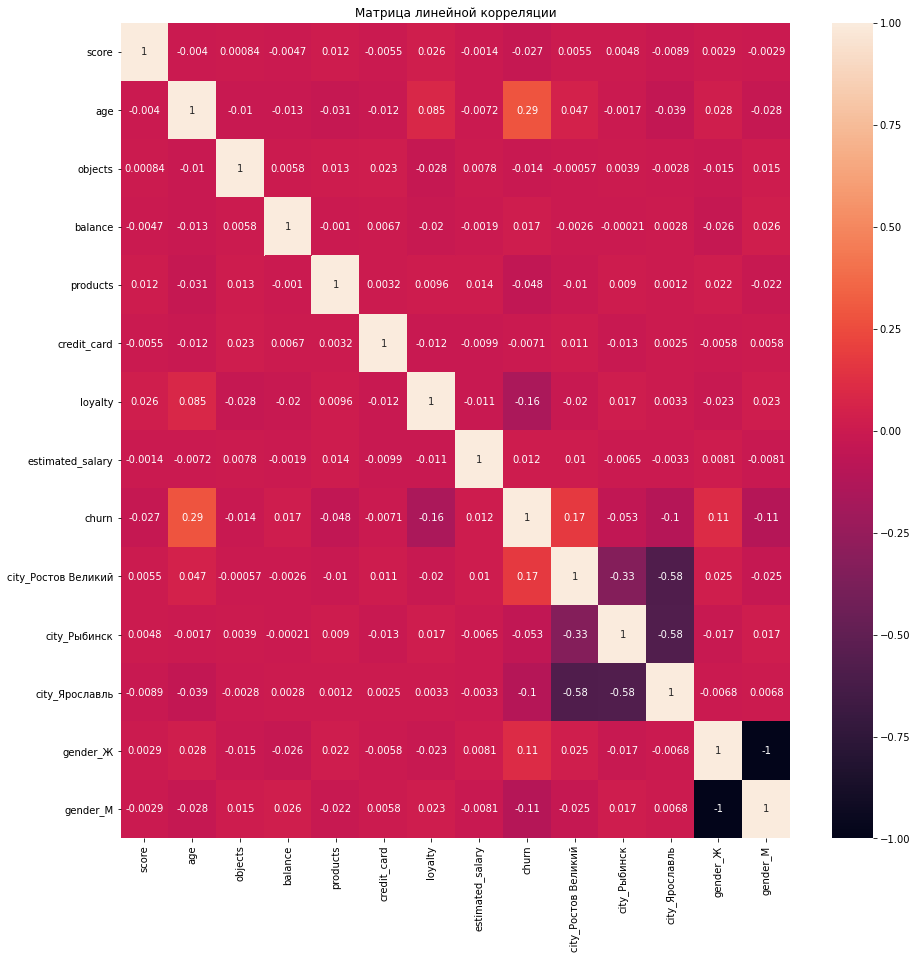

In [19]:
plt.figure(figsize = (15,15))
sns.heatmap(df_binar.corr(), annot=True)
plt.title('Матрица линейной корреляции')
plt.show()

***Общий вывод по EDA***

*Мы изучили основные статистики, посмотрели на распределения признаков, исследовали корреляции параметров. Среди аномалий был выделен всплекс кол-ва клиентов в скоринге у максимальных значений. Из необычного - распределение в зарплате и кол-ве объектов в собственности, однородность данных может свидетельствовать о некоторых особенностях выборки клиентов.*

## Портрет клиентов склонных к оттоку

***Посмотрим на статистики и распределения количественных и категориальных признаков по группам оттока***

### Средние по группам оттока

In [20]:
mean_churn = df_noid.replace({'gender':gender_dict}).groupby('churn').agg('mean').round(2).T
mean_churn_overall = mean_churn.join(mean_std)
mean_churn_overall = mean_churn_overall.rename(columns = {0:'mean_stay', 1:'mean_churn', 'mean':'overall_mean'})
mean_churn_overall

,mean_stay,mean_churn,overall_mean,std
score,651.85,645.35,650.53,96.65
gender,0.57,0.44,0.55,0.50
age,37.41,44.84,38.92,10.49
objects,5.03,4.93,5.01,2.89
balance,119535.86,120746.97,119827.49,30095.06
products,1.54,1.48,1.53,0.58
credit_card,0.71,0.70,0.71,0.46
loyalty,0.55,0.36,0.52,0.50
estimated_salary,99738.39,101465.68,100090.24,57510.49


Видна разница в параметрах пол, возраст и лояльность(активность), остальные параметры довольно близки. Изучим распределения по признакам.

In [21]:
df_churn = df.query('churn == 1')
df_no_churn = df.query('churn == 0')

### Количественные признаки

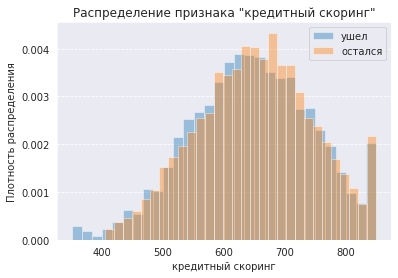

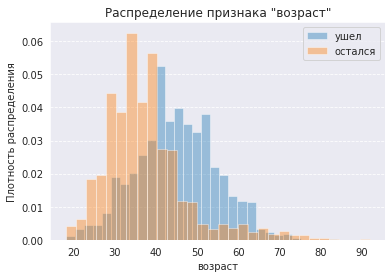

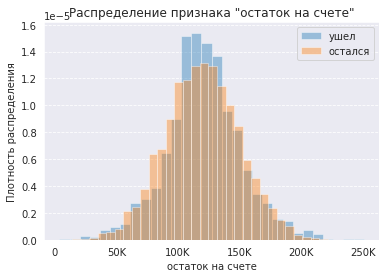

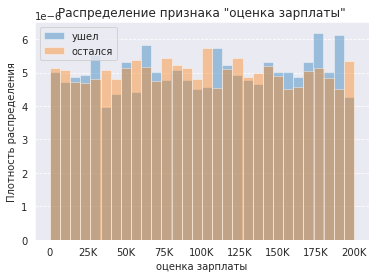

In [22]:
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 
    into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

def churn_hist(col):
    '''
    Takes the column name as input, gets rid of nans, 
    then builds two histograms for 'churn' and 'stay' groups on the same axes.
    The ticks are formated in engineering style.
    '''
    A = df_no_churn[col]
    A_no_nan = A[~np.isnan(A)]
    B = df_churn[col]
    B_no_nan = B[~np.isnan(B)]

    sns.distplot(B_no_nan, kde=False, bins=30, norm_hist=True)
    sns.distplot(A_no_nan, kde=False, bins=30, norm_hist=True)
    plt.title(f'Распределение признака "{df_columns_dict[col]}"')
    plt.xlabel(df_columns_dict[col])
    plt.ylabel('Плотность распределения')
    plt.legend(labels = ['ушел', 'остался'])
    plt.grid(axis='y', linestyle='--')
    ax = plt.gca()
    #ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(reformat_large_tick_values))





with sns.axes_style('dark'):
    for col in df_quantitative.columns:
        churn_hist(col)
        plt.show()

Видны сильные различия в параметре возраст, около 40 лет видна разница в распределении. Получается что люди после 40 чаще уходят из банка. Также видна небольшая разница в параметре остаток на счете - люди с остатоком от 100 до 150тыс уходят чуть чаще, также уходят люди с остатоком более 200тыс.

### Категориальные и дискретные признаки

Ростов Великий    0.324432
Рыбинск           0.166734
Ярославль         0.161548
Name: city, dtype: float64


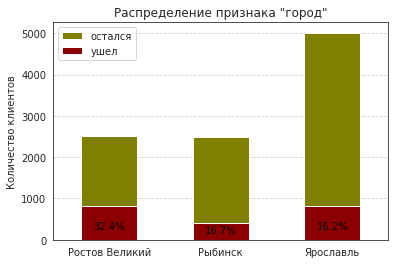

Ж    0.250715
М    0.164559
Name: gender, dtype: float64


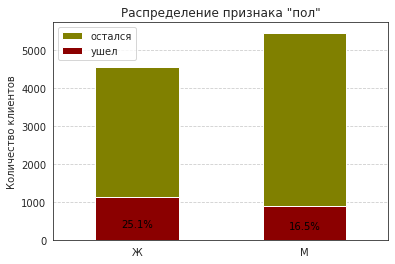

0     0.230024
1     0.224155
2     0.191794
3     0.211100
4     0.205258
5     0.206522
6     0.202689
7     0.172179
8     0.192195
9     0.216463
10    0.206122
Name: objects, dtype: float64


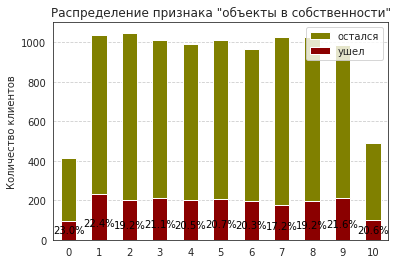

1    0.277144
2    0.075817
3    0.827068
4    1.000000
Name: products, dtype: float64


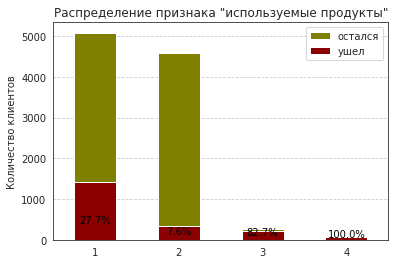

0    0.208149
1    0.201843
Name: credit_card, dtype: float64


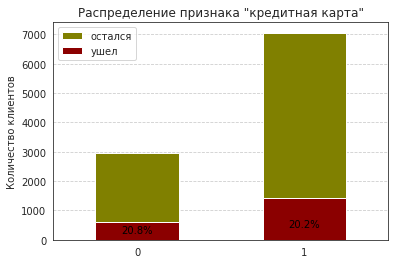

0    0.268509
1    0.142691
Name: loyalty, dtype: float64


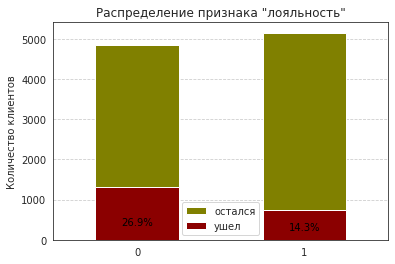

In [23]:
def cat_bar_stack(col):
    '''
    Function takes column value and builds a stacked bar-chart using pandas.plot with 
    kind='bar'. The stacked groups are 'stay' and 'churn'. The 'churn' bars are labelled
    with percentages.
    '''
    data_all = df[col].value_counts().sort_index()
    data_churn = df_churn[col].value_counts().sort_index()#order the churn data the same way as al
    percentage = (data_churn / data_all).sort_index()
    print(percentage)
    
    bar1 = data_all.plot(kind='bar', color='olive')
    bar2 = data_churn.plot(kind='bar', color='darkred')
    
    #Print percentage of churn in each class
    for i, rect in enumerate(bar2.patches):
        n = int(len(bar2.patches) / 2.0) #We have 2*n patches, but need only the second half.
        if i >= n:
            height = rect.get_height()

            plt.text(rect.get_x() + rect.get_width() / 2.0, height / 4.0, f'{percentage.iloc[int(i-n)]:1.1%}', 
                     ha='center', va='bottom', color='black')

    plt.title(f'Распределение признака "{df_columns_dict[col]}"')
    plt.xlabel('')
    plt.xticks(rotation=360)#strange but it works
    plt.ylabel('Количество клиентов')
    plt.grid(axis='y', linestyle='--')
    plt.legend(['остался', 'ушел'])

    

with sns.axes_style('white'):
    for col in df_category.drop('churn', axis=1).columns:
        cat_bar_stack(col)
        plt.show()

Наибольший отток приходится на Ростов - более 32%, чаще всего это женщины - 25%, клиенты которые пользуются 3-4 продуктами(отток 80-100%), и в меньшей степени люди пользующиеся 1 продуктом - около 27%. Доля оттока среди не лояльных клиентов - почти 27%. Стоит отметить, что наличие или отсутствие кредитной карты не является особенностью ухода клиента. Кол-во объектов в собственности также не является параметром влияющим на отток.

В Рыбинске и Ярославле отток чуть больше 16%, чаще это мужчины, клиенты пользующиеся 2 продуктами банка, показатель в параметре лояльность - около 14%. 

На основе полученных данных можем составить портрет клиентов сколнных к оттоку и клиентов которые вероятнее всего останутся с банком.

### Портреты клиентов

***Клиент склонный к оттоку***

- Город проживания: Ростов Великий
- Пол: женский
- Возраст: старше 40
- Кол-во продуктов в использовании: 1 продукт или же 3, 4 продукта
- Лояльность(активность): нелоялен
- Остаток на счете: от 100 до 150 тыс. или больше 200 тыс.

***Клиент не склонный к оттоку***

- Город проживания: Ярославль, Рыбинск
- Пол: мужской
- Возраст: моложе 40
- Кол-во продуктов в использовании: 2 продукта
- Лояльность(активность): лоялен
- Остаток на счете: 75-100тыс, 150-200тыс

## Проверка гипотез

### Проверка гипотезы о различии дохода клиентов, которые остались и которые ушли в отток.

In [24]:
df['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

In [25]:
df.groupby('churn')['estimated_salary'].agg(['mean', 'median', 'std']).round(2)

,mean,median,std
churn,,,
0,99738.39,99645.04,57405.59
1,101465.68,102460.84,57912.42


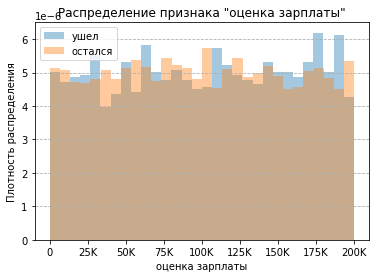

In [26]:
churn_hist('estimated_salary')

Формы распределения практически идентичны, можно проверить гипотезу посредством теста Манна-Уитни.
Сформулируем нулевую и альтернативную гипотезы:

H0: Между группами "ушел" и "остался" нет различия в доходах

H1: Между группами есть различие в доходах

In [27]:
ALPHA = .05
def mannwhit (data1, data2, alpha):
    '''
    Для заданных двух групп и ур.знач. alpha проводит тест Манна-Уитни 
    для установления статистического различия между данными
    '''
    print(f'Уровень значимости теста = {alpha}')
    p_v = st.mannwhitneyu(data1, data2).pvalue
    
    print("p-value = {0:.15f}".format(p_v))
    if (p_v < alpha):
        print('Статистически значимая разница')
    else:
        print('Нет статистически значимой разницы')

mannwhit(df_churn['estimated_salary'], df_no_churn['estimated_salary'], ALPHA)    

Уровень значимости теста = 0.05
p-value = 0.227051509301538
Нет статистически значимой разницы


Значение p-value 0.22 при статистической значимости 5% - нулевую гипотезу не отвергаем. Между группами ушедших и оставшихся клиентов статистически значимые различия доходов отсутствуют. 

### Гипотеза о различии доли оттока среди лояльных и нелояльных клиентов

0    0.268509
1    0.142691
Name: loyalty, dtype: float64


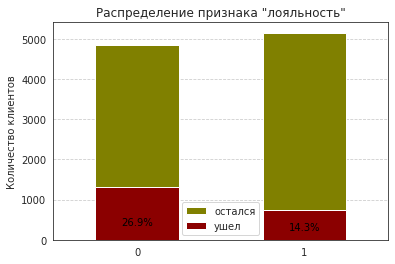

In [28]:
with sns.axes_style('white'):
    cat_bar_stack('loyalty')

Сформируем гипотезы:

H0: доли оттока равны для лояльных и нелояльных клиентов

H1: доли оттока различны для лояльных и нелояльных клиентов

*Нулевую и альтернативную гипотезы проверим с помощью z-теста.*

In [29]:
def test_share_eq(dep_col, ind_col, ALPHA):
    '''
    Функция получает на вход названия колонки зависимого параметра (того чью долю считаем)
    и независимого (того по которому группируем). Оба параметра должны быть булевы. Также
    на вход идет уровень значимости теста, ALPHA.
    
    Расчитывает необходимые доли и проводит Z-test на равенство долей с уровнем значимости ALPHA
    
    Печатает ALPHA, p-value и результат теста.
    '''
    group_size = df[ind_col].value_counts() #размер групп
    share_size = df.groupby(ind_col)[dep_col].sum() #размер целевых подгрупп в группах
   
    
    p = share_size / group_size #доли
    p_combined = share_size.sum() / group_size.sum() #общая доля
    # разница пропорций в датасетах
    difference = p[0] - p[1]
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_size[0] + 1/group_size[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'Уровень значимости: {ALPHA}')
    print('p-значение: {0:.15f}'.format(p_value))

    if (p_value < ALPHA):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

test_share_eq('churn', 'loyalty', .05)

Уровень значимости: 0.05
p-значение: 0.000000000000000
Отвергаем нулевую гипотезу: между долями есть значимая разница


Значение p-value 0.00, при статистической значимости 5% - нулевую гипотезу отвергаем. 
Среди лояльных клиентов доля оттока меньше чем у нелояльных. Гипотеза подтвердилась!

## Общий вывод и рекомендации

Мы провели исследование данных клиентов банка "Метанпром", составили портреты клиентов, проверили гипотезы.

***Из полученных результатов, можно сделать следующие выводы:***

- Главные признаки оттока: пол(в основном женский), возраст(чаще выше 40 лет), отсутствие лояльности(активности) - 0
- Наибольший процент оттока наблюдается в Ростове Великом - 32% клиентов, в Рыбинске и Ярославле в два раза ниже - около 16%
- В портретах клиентов мы вывели основные параметры людей склонных к оттоку и пользователей которые остаются с банком. К оттоку сколнны: женщины старше 40 лет, проживающие в Ростове Великом, имеющие в собственности 0-1 объектов, пользующиеся 1 или 3-4 продуктами банка, имеющие зарплату в диапазонах 100-150тыс, или более 200тыс. Чаще всего остаются с банком мужчины моложе 40, проживающие в Рыбинске и Ярославле, пользующиеся 2 продуктами банка, имеющие зарплату в диапазонах 75-100тыс и 150-200тыс, имеющие в собственности 2 и более объекта.
- Гипотеза о статистически значимом различии дохода клиентов, которые ушли, и тех, которые остались, не подтвердилась
- Гипотеза о различии доли тех, кто ушел в отток, среди лояльных и нелояльных клиентов подтвердилась. Лояльные клиенты чаще остаются с банком.


***Рекомендации:***

- Обратить внимание на филиал находящийся в Ростове Великом, выяснить почему именно там отток почти в два раза превышает показатель других городов.
- Изучить особенности населения старше 40 лет, принять меры которые предотвратят отток среди людей старшего поколения. 
- Работать над общим повышением лояльности клиентов.
- Изучить особенности клиентов женского пола, возможно, отделу маркетинга стоит сделать упор на разработку мероприятий направленных на удержание женской половины пользователей банка.
